<a href="https://colab.research.google.com/github/sunny9sinha/TSAI_Session_10_Assignment/blob/main/Session_10_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
device

device(type='cuda')

In [48]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2021-07-17 21:39:11--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.37.37, 99.86.37.53, 99.86.37.74, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.37.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  --.-KB/s    in 0.05s   

2021-07-17 21:39:11 (52.3 MB/s) - ‘data.zip.1’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/eng-fra.txt        
replace data/names/Arabic.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: 

In [49]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [50]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [51]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [52]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [53]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra')
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
eng 2803
fra 4345
['you are beautiful .', 'vous etes beaux .']


In [54]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [55]:
!pip install bcolz
import bcolz
import numpy as np
import pickle

words = []
idx = 0
word2idx = {}
glove_path = '/content/drive/MyDrive/Colab Notebooks'
vectors = bcolz.carray(np.zeros(1), rootdir=f'{glove_path}/6B.50.dat', mode='w')

with open(f'{glove_path}/glove.6B.50d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
    
vectors = bcolz.carray(vectors[1:].reshape((400000, 50)), rootdir=f'{glove_path}/6B.50.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'{glove_path}/6B.50_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'{glove_path}/6B.50_idx.pkl', 'wb'))


In [56]:
vectors = bcolz.open(f'{glove_path}/6B.50.dat')[:]
words = pickle.load(open(f'{glove_path}/6B.50_words.pkl', 'rb'))
word2idx = pickle.load(open(f'{glove_path}/6B.50_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [57]:
matrix_len = input_lang.n_words
weights_matrix = np.zeros((matrix_len, 50))
words_found = 0

for i, word in input_lang.index2word.items():
    try: 
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(50, ))

In [58]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = input_lang.n_words, 50
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.from_numpy(weights_matrix)})
    if non_trainable:
        emb_layer.weight.requires_grad = False
    return emb_layer, num_embeddings, embedding_dim


In [59]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)

        #self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [60]:
matrix_len_de = output_lang.n_words
weights_matrix_de = np.zeros((matrix_len_de, 50))
words_found_de = 0

for i, word in output_lang.index2word.items():
    try: 
        weights_matrix_de[i] = glove[word]
        words_found_de += 1
    except KeyError:
        weights_matrix_de[i] = np.random.normal(scale=0.6, size=(50, ))

In [61]:
def create_emb_layer_de(weights_matrix_de, non_trainable=False):
    num_embeddings, embedding_dim = output_lang.n_words, 50
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.from_numpy(weights_matrix_de)})
    if non_trainable:
        emb_layer.weight.requires_grad = False
    return emb_layer, num_embeddings, embedding_dim

In [62]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding, num_embeddings, embedding_dim = create_emb_layer_de(weights_matrix_de, True)

        #self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [63]:
matrix_len_att = output_lang.n_words
weights_matrix_att = np.zeros((matrix_len_att, 50))
words_found_att = 0

for i, word in output_lang.index2word.items():
    try: 
        weights_matrix_att[i] = glove[word]
        words_found_att += 1
    except KeyError:
        weights_matrix_att[i] = np.random.normal(scale=0.6, size=(50, ))

In [64]:
def create_emb_layer_att(weights_matrix_att, non_trainable=False):
    num_embeddings, embedding_dim = output_lang.n_words, 50
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.from_numpy(weights_matrix_att)})
    if non_trainable:
        emb_layer.weight.requires_grad = False
    return emb_layer, num_embeddings, embedding_dim

In [65]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        #self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.embedding, num_embeddings, embedding_dim = create_emb_layer_att(weights_matrix_att, True)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [66]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [67]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [68]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [69]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [70]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [71]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

1m 7s (- 15m 51s) (5000 6%) 3.9046
2m 13s (- 14m 25s) (10000 13%) 3.4218
3m 19s (- 13m 18s) (15000 20%) 3.2237
4m 25s (- 12m 8s) (20000 26%) 3.0269
5m 30s (- 11m 1s) (25000 33%) 2.9602
6m 36s (- 9m 54s) (30000 40%) 2.8272
7m 41s (- 8m 47s) (35000 46%) 2.7511
8m 48s (- 7m 42s) (40000 53%) 2.7046
9m 55s (- 6m 36s) (45000 60%) 2.6657
11m 0s (- 5m 30s) (50000 66%) 2.6027
12m 5s (- 4m 23s) (55000 73%) 2.5590
13m 10s (- 3m 17s) (60000 80%) 2.5293
14m 15s (- 2m 11s) (65000 86%) 2.4444
15m 19s (- 1m 5s) (70000 93%) 2.4338
16m 24s (- 0m 0s) (75000 100%) 2.3639


<Figure size 432x288 with 0 Axes>

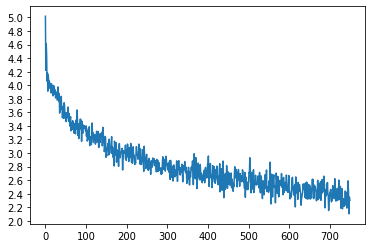

In [72]:
hidden_size = 50
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [73]:
evaluateRandomly(encoder1, attn_decoder1)

> they re all watching us .
= ils nous regardent tous .
< elles sont tous a tous . <EOS>

> i m ticklish .
= je suis chatouilleuse .
< je suis en . <EOS>

> i m very much aware of the danger .
= je suis tres conscient du danger .
< je suis tres occupe pour l <EOS>

> they are spraying the fruit trees .
= ils epandent les arbres fruitiers .
< elles sont des train de . . <EOS>

> i m pleased with his performance .
= je suis satisfait de sa prestation .
< je suis suis pour de . <EOS>

> i m not really angry .
= je ne suis pas vraiment en colere .
< je ne suis pas si fatigue . <EOS>

> we re not really brothers .
= nous ne sommes pas vraiment freres .
< nous ne sommes pas si tres . <EOS>

> you are a good boy .
= vous etes un bon garcon .
< tu es un personne menteur . <EOS>

> you are in my way .
= tu es sur mon chemin .
< tu es le qui . . <EOS>

> he s ready to go .
= il est pret a partir .
< il est a a . . . <EOS>



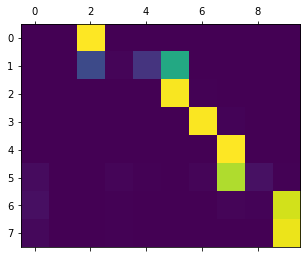

In [74]:
%matplotlib inline
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "my ideas are different from yours .")
plt.matshow(attentions.numpy())

input = my ideas are different from yours .
output = tu es de de vous . . <EOS>


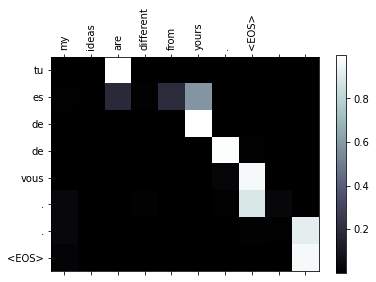

input = i forgot about that .
output = je suis certain . <EOS>


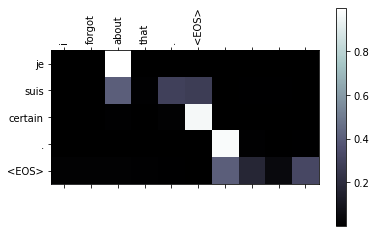

input = you are a good boy .
output = tu es un personne menteur . <EOS>


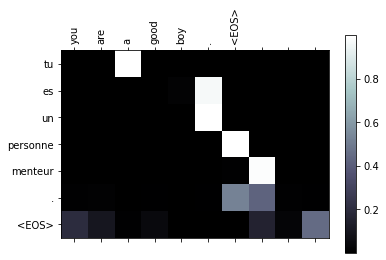

input = you are in my way .
output = tu es le la . . <EOS>


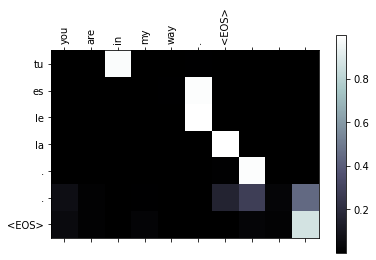

In [77]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("my ideas are different from yours .")

evaluateAndShowAttention("i forgot about that .")

evaluateAndShowAttention("you are a good boy .")

evaluateAndShowAttention("you are in my way .")